In [63]:
import numpy as np
import pandas as pd 
import random

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
def train_test_split(data, split_date, h=1):
    ind = data.index
    
    X = data.loc[ind[:-h], ['year', 'month', 'weekofyear', 'diff1', 'usd_diff_1', 'eur_diff_1']]    
    y = data.loc[ind[h:], 'Значение']    
    
    df = X
    df.loc[:, 'Значение'] = y.values
    
    df_train = df[df.index.get_level_values('Дата') < split_date]
    df_test = df[df.index.get_level_values('Дата') >= split_date]    
    
    return df_train, df_test

In [144]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [110]:
def plot_predictions(y, y_pred):
    plt.figure( figsize=(15, 4))

    plt.xlabel('Время')
    plt.ylabel('$US')
    plt.plot(df_test.index, y_pred, label='прогноз' )
    plt.plot(df_test.index, y, label='факт')
    plt.title('Brent, $US', size=14)

    plt.legend()
    plt.show()

In [153]:
def predict_f_d(ind, df_test, t_name, s_name, model_gb): 
    df_test_rolling = df_test.loc[ind, [t_name] + s_name] 

    for i in range(len(ind)):
        if i == 1:
            value = df_test_rolling.loc[ind[i - 1], t_name] - df_test.loc[df_test.index[t0 - 1], t_name] 
            df_test_rolling.loc[ind[i], 'diff_1'] = value            
            value = df_test_rolling.loc[ind[i - 1], t_name] - df_test.loc[df_test.index[t0 - 2], t_name]
            df_test_rolling.loc[ind[i], 'diff_2'] = value

        y_pred = model_gb.predict(pd.DataFrame(df_test_rolling.loc[ind[i], s_name]).T)[0]
        df_test_rolling.loc[ind[i], t_name] = y_pred

    df_test_rolling = df_test_rolling.loc[ind[1]:, :]
    
    return df_test_rolling

## Читаем данные

In [121]:
Path_Brent = 'my_BRENT2019.csv'

In [122]:
data = pd.read_csv(Path_Brent, index_col=[0], parse_dates=[0])

data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [123]:
first_diff =np.array(data.iloc[1:,0].values - data.iloc[:-1,0].values).astype('float32') 
data['diff1'] = 0.0
data['diff1'] =  data['diff1'].astype('float') 
data['diff1'].values[1:] = first_diff

In [124]:
data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff1
Дата,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,0.00
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,0.52
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,-0.32
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,0.05
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,0.01


In [125]:
data_w = data.copy().resample('W').mean()
data_w.shape

(470, 12)

In [126]:
data_w.head(5)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff1
Дата,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000,0.052000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667,0.288333
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000,-0.021667
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000,0.118333
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000,0.791667


In [127]:
file_name = 'RC_F01_09_2010_T01_09_2019.xlsx'
data_usd = pd.read_excel(file_name, index_col=[0], parse_dates=[0]).sort_index()

In [128]:
data_usd = data_usd.set_index('data').drop('cdx', axis=1)
data_usd.columns = ['usd']
data_usd = data_usd.resample('W').mean()

In [129]:
data_usd.loc[1:, 'usd_diff_1'] = data_usd['usd'][:-1].values - data_usd['usd'][1:].values
data_usd.head(2)

,usd,usd_diff_1
data,,
2010-09-05,30.76125,NaN
2010-09-12,30.79402,-0.03277


In [132]:
file_name = 'R_E01_09_2010_T01_09_2019.xlsx'
data_e = pd.read_excel(file_name, index_col=[0], parse_dates=[0]).sort_index()

In [133]:
data_e = data_e.set_index('data').drop('cdx', axis=1)
data_e.columns = ['eur']
data_e = data_e.resample('W').mean()

In [134]:
data_e.loc[1:, 'eur_diff_1'] = data_e['eur'][:-1].values - data_e['eur'][1:].values
data_usd.head(2)

,usd,usd_diff_1
data,,
2010-09-05,30.76125,NaN
2010-09-12,30.79402,-0.03277


In [135]:
data_w = pd.concat([data_w, data_usd.usd_diff_1, data_e.eur_diff_1], axis=1)
data_w.head(2)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff1,usd_diff_1,eur_diff_1
Дата,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.0,3.0,3.0,246.0,35.0,4.0,0.000000,0.2,0.000000,0.052000,NaN,NaN
2010-09-12,77.673333,2010.0,9.0,8.5,3.0,251.5,36.0,2.5,0.166667,0.0,0.166667,0.288333,-0.03277,-0.088685


In [136]:
data_w.columns

Index(['Значение', 'year', 'month', 'dayofmonth', 'quarter', 'dayofyear',
       'weekofyear', 'dayofweek', 'is_holiday', 'is_prev_holiday',
       'is_next_holiday', 'diff1', 'usd_diff_1', 'eur_diff_1'],
      dtype='object')

In [137]:
features = ['Значение', 'year', 'month', 'weekofyear', 'diff1', 'usd_diff_1', 'eur_diff_1']

In [138]:
data_w_f = data_w[features]
data_w_f.head()

,Значение,year,month,weekofyear,diff1,usd_diff_1,eur_diff_1
Дата,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,35.0,0.052000,NaN,NaN
2010-09-12,77.673333,2010.0,9.000000,36.0,0.288333,-0.03277,-0.088685
2010-09-19,78.693333,2010.0,9.000000,37.0,-0.021667,-0.05270,-0.684380
2010-09-26,78.518333,2010.0,9.000000,38.0,0.118333,-0.15248,-1.064900
2010-10-03,81.211667,2010.0,9.333333,39.0,0.791667,0.47156,-0.309020


## Строим модель

In [139]:
data_w_f = data_w_f.fillna(0)

In [140]:
split_date = '2018-02-02'
df_train, df_test = train_test_split(data_w_f, split_date)

In [141]:
df_train.head()

,year,month,weekofyear,diff1,usd_diff_1,eur_diff_1,Значение
Дата,,,,,,,
2010-09-05,2010.0,9.000000,35.0,0.052000,0.00000,0.000000,77.673333
2010-09-12,2010.0,9.000000,36.0,0.288333,-0.03277,-0.088685,78.693333
2010-09-19,2010.0,9.000000,37.0,-0.021667,-0.05270,-0.684380,78.518333
2010-09-26,2010.0,9.000000,38.0,0.118333,-0.15248,-1.064900,81.211667
2010-10-03,2010.0,9.333333,39.0,0.791667,0.47156,-0.309020,84.146667


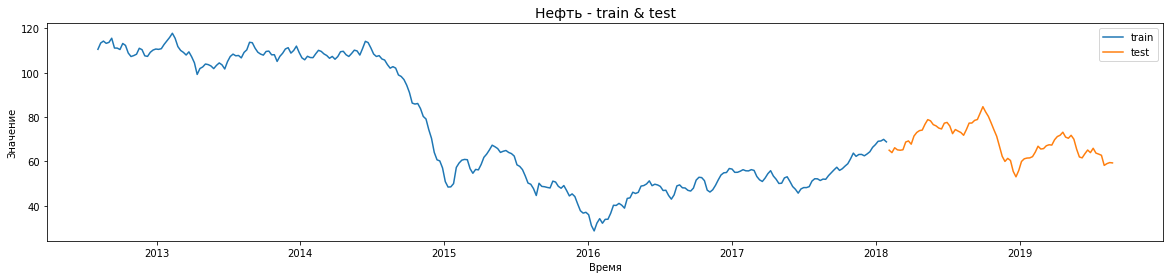

In [142]:
plt.figure( figsize=(20, 4))
plt.xlabel('Время')
plt.ylabel('Значение')
plt.plot(df_train.index[100:], df_train['Значение'][100:], label='train' )
plt.plot(df_test.index, df_test['Значение'], label='test')
plt.title(f'Нефть - train & test', size=14)
plt.legend()
plt.show()

In [143]:
model_gb = GradientBoostingRegressor(max_depth=3, random_state=42, n_estimators=100)
model_gb.fit(df_train[['year', 'month', 'weekofyear', 'diff1', 'usd_diff_1', 'eur_diff_1']], df_train[['Значение']])

C:\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

mse: 56.66268044640002
mae: 6.190293706972728
R2: -0.16186361068489274
mape: 8.977237800215473%


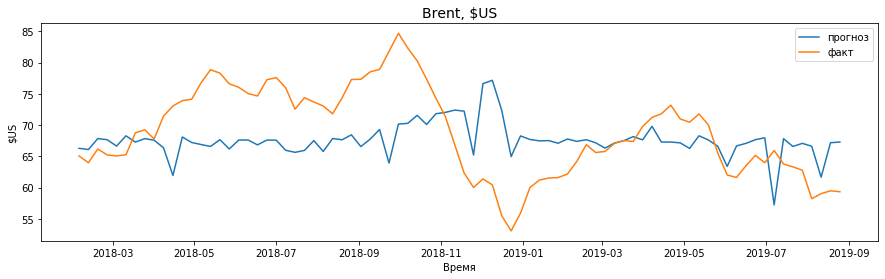

In [150]:
y_pred = model_gb.predict(df_test[['year', 'month', 'weekofyear', 'diff1', 'usd_diff_1', 'eur_diff_1']])

y = df_test['Значение']
mse = mean_squared_error(y, y_pred) 
mae = mean_absolute_error(y, y_pred) 
R2 = r2_score(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
print(f'mse: {mse}\nmae: {mae}\nR2: {R2}\nmape: {mape}%')

plot_predictions(y, y_pred)

## 1 точка от текущей

Берём несколько разных точек, по ним делаем предсказание и считаем ошибку

In [163]:
p = 1
n = 50
starting_points = list(range(10, 100, 10))
print(starting_points)

results = []
for t0 in starting_points:    
    ind = df_test.index[t0 : t0 + p + 1]
    predict_f_d = recalculate_df_test(ind, df_test, 'Значение', ['year', 'month', 'weekofyear', 'diff1', 'usd_diff_1', 'eur_diff_1'] , model_gb)
    
    prediction = predict_f_d.loc[ind[p],'Значение']
    actual = df_test.loc[ind[p],'Значение']
    
    result = abs((actual - prediction) / actual * 100)              
    results.append(result)
    
mape = np.array(results).mean()
print(f'mape = {round(mape, 3)}%')

[10, 20, 30, 40, 50, 60, 70, 80, 90]


IndexError: index 1 is out of bounds for axis 0 with size 0

Разница минимальна.